# Load representative profile extraction test code

<!-- **source codes are under /src** -->

owner: Yi Ju. last updated: 2023/03/09

**contact the owner before you edit this notebook (incl. run)**

**AND very clearly mark where you edit (and why)**

<!-- ### Debug tips
you can check `mpc.cache` to find the last state before bug occurs -->

In [1]:
import os
import sys
src_path = sys.path[0].replace("notebooks", "src")
# data_path = sys.path[0].replace("notebooks", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("notebooks", "output")

import warnings
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import time

from profile_extraction import ProfileExtraction
from data_loader import UCSD_dataloader
from data_pool import DataPool
from utils.plot_utils import *

g:\Anaconda\Anaconda3\envs\base38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
loader = UCSD_dataloader
loaded = loader(tstart=datetime(2019,1,1,0,0), tend=datetime(2020,1,1,0,0), delta=0.25, 
                bld="Hopkins", pv="Hopkins", ev="OSLER", pv_to_bld=0.5, ev_to_bld=None, Pmax=10)
data = loaded.get_data()

!!!!!!!!!! MISSING VALUES !!!!!!!!!! || [bld] has [4] missing values
!!!!!!!!!! MISSING VALUES !!!!!!!!!! || [pv] has [4] missing values
!!!!!!!!!! EV SHORT DURATION !!!!!!!!!! || drop 81 sessions


In [8]:
len(data["ev_sessions"])/365

39.013698630136986

In [3]:
tstart, tend = datetime(2019, 1, 1, 0, 0), datetime(2020, 1, 1, 0, 0)

pe = ProfileExtraction(data=data, tstart=tstart, tend=tend)

In [4]:
# rp is a [RepProfiles] object, see src/profile/extraction.py
rp = pe.rep_profile_extraction(alg="sample", K=20, incl_ev=True, ev_how_to="unif",
                               dist_metric="l2_center", importance_func=None)

# save the extracted representative profiles to xlsx
rp.save(save_fn="Mar19-Yi-base_rep_profiles.xlsx", save_path=os.path.join(out_path, "debug_test"))

# convert profiles to params -> for battery optimizer
params = rp.profiles_to_params()

KeyError: 'load_ev_unif'

In [11]:
save_fn = "Mar19-Yi-base_rep_profiles.npy"
np.save(os.path.join(out_path, "debug_test", save_fn), params)

In [14]:
params = np.load(os.path.join(out_path, "debug_test", save_fn), allow_pickle=True)

In [4]:
# rp is a [RepProfiles] object, see src/profile/extraction.py
rp = pe.rep_profile_extraction(alg="cluster", K=20, incl_ev=True, ev_how_to="unif")

# save the extracted representative profiles to xlsx
rp.save(save_fn="rep_profile_test.xlsx", save_path=os.path.join(out_path, "debug_test"))

# convert profiles to params -> for battery optimizer
params = rp.profiles_to_params()

# calculate overall stats of the profiles
# TODO: now, it is empty
stats = rp.rep_profile_analysis()

g:\Anaconda\Anaconda3\envs\base38\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


g:\Anaconda\Anaconda3\envs\base38\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
e:\jerry ( 2021.1.20拷贝 )\Berkeley\Github Repo\Battery_sizing\src\profile_extraction.py:540: UserWarning: The sum of weights are 0.75. You may want to check.
  warnings.warn("The sum of weights are {:.2f}. You may want to check.".format(prob.sum()))
g:\Anaconda\Anaconda3\envs\base38\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


K = 5:  sum of weights: 0.75
K = 20:  sum of weights: 0.82


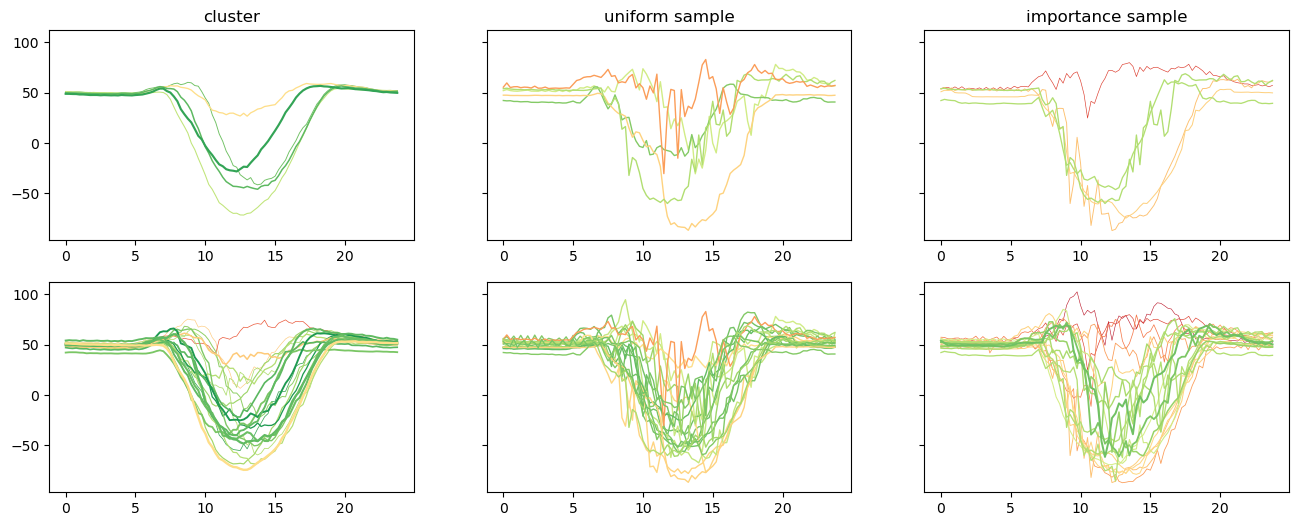

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(16,6), sharey=True)

ref, max_ref = None, None

ev_how_to = "unif"

for i in range(2):
    K = 5 if i == 0 else 20
    for j in range(3):
        if j == 0:
            res = pe.rep_profile_extraction(alg="cluster", K=K, incl_ev=True, ev_how_to=ev_how_to)
            title = "cluster"
        elif j == 1:
            res = pe.rep_profile_extraction(alg="sample", K=K, incl_ev=True, ev_how_to=ev_how_to, dist_metric=None, importance_func=None)
            title = "uniform sample"
        elif j == 2:
            res = pe.rep_profile_extraction(alg="sample", K=K, incl_ev=True, ev_how_to=ev_how_to, dist_metric="l2_center", importance_func=None)
            title = "importance sample"
            print("K = {}:  sum of weights: {:.2f}".format(K, res.prob.sum()))
        ax = axs[i, j]

        if ref is None:
            ref = pe.cache["data_2D"].mean(axis=0).values
            max_ref = np.sqrt(((pe.cache["data_2D"] - ref.reshape(1,-1)) ** 2).mean(axis=1).values).max()

        rep_profile_visual(res.agg_power, res.prob, cmap_name="RdYlGn", ax=ax, ref=ref, max_ref=max_ref)
        if i == 0:
            ax.set_title(title)




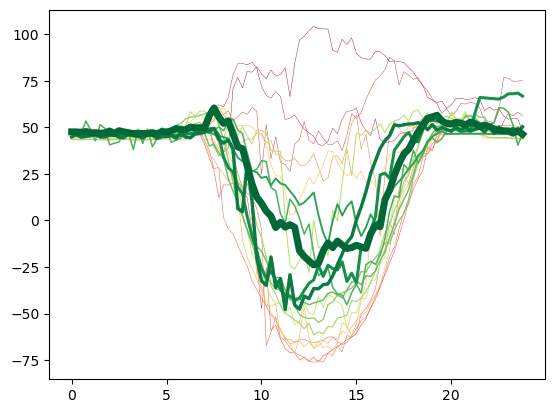

In [7]:
rep_profile_visual(res.agg_power, res.prob)